# Multi Output Prediction with FastAi and entity embeddings

This notebook is the "start over and try again" version of this project, because of the lack of success in v1 using scikit-learn. The majority of this notebook follows the examples from <i>Deep Learning For Coders with fastai & PyTorch</i> (Howard & Gugger, 2020), specifically <i>Chapter 9: Tabular Modeling Deep Dive</i> from the GitHub repo found here: <a href="https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb">Ch 9 Tabular Modeling Deep Dive</a>

---

## Load Libraries 


In [1]:
# for final notebook run, time it
import datetime as dt
full_nb_run_start = dt.datetime.now()

In [2]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!pip install -Uqq fastbook waterfallcharts treeinterpreter dtreeviz
from fastai.tabular.all import *

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [3]:
import fastbook
fastbook.setup_book()

In [4]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

import numpy as np
np.random.seed(42)

---

## Load Data, Identify Features and Targets by types

In [5]:
df = pd.read_csv('./data/clean_data.csv', low_memory=False)

In [6]:
df.columns

Index(['CalendarYear', 'OfficeCity', 'OfficeState', 'OfficeZip', 'OfficeName',
       'AccountCity', 'AccountState', 'AccountZip', 'AccountNaicsName',
       'MarketName', 'ServiceName', 'ServiceLineName', 'IndustryName',
       'JobTaxComplexity', 'JobName', 'ChargeHours', 'ProductionRevActual',
       'Cost', 'NumAssociatesOnJob', '# of Locations', 'Annual Sales',
       'Assets', 'Employees', 'SEC/Publicly Traded'],
      dtype='object')

---

As before, we define our columns by category.

In [7]:

cats = ['CalendarYear', 'OfficeCity', 'OfficeState', 'OfficeZip', 'OfficeName',
       'AccountCity', 'AccountState', 'AccountZip', 'AccountNaicsName',
       'MarketName', 'ServiceName', 'ServiceLineName', 'IndustryName',
       'JobName','SEC/Publicly Traded']
ords = ['JobTaxComplexity','Annual Sales','Assets', 'Employees']
numerics = ['# of Locations']
targets = ['ChargeHours', 'ProductionRevActual',
       'Cost', 'NumAssociatesOnJob']
df = df[cats+ords+numerics+targets]
df.head()

,CalendarYear,OfficeCity,OfficeState,OfficeZip,OfficeName,AccountCity,AccountState,AccountZip,AccountNaicsName,MarketName,ServiceName,ServiceLineName,IndustryName,JobName,SEC/Publicly Traded,JobTaxComplexity,Annual Sales,Assets,Employees,# of Locations,ChargeHours,ProductionRevActual,Cost,NumAssociatesOnJob
0,2020,Wausau,WI,54403.0,"Wausau, WI (30)",Rothschild,WI,54474,Food (Health) Supplement Stores,North Central WI,Accounting assistance - A&A,Audit & Accounting (10),Mfg. Retail Distribution,Accounting assistance - A&A-2013,No,Not Applicable,5M - 9.9M,Unknown,Unknown,0.0,0.0,0.0,0.00,1
1,2020,Wausau,WI,54403.0,"Wausau, WI (30)",Rothschild,WI,54474,Food (Health) Supplement Stores,North Central WI,Property Tax,Tax (20),Mfg. Retail Distribution,Property Tax-260068,No,Not Applicable,5M - 9.9M,Unknown,Unknown,0.0,0.8,175.5,29.63,4
2,2021,Wausau,WI,54403.0,"Wausau, WI (30)",Rothschild,WI,54474,Food (Health) Supplement Stores,North Central WI,Property Tax,Tax (20),Mfg. Retail Distribution,Property Tax-260068,No,Not Applicable,5M - 9.9M,Unknown,Unknown,0.0,0.6,72.0,16.74,2
3,2020,Wausau,WI,54403.0,"Wausau, WI (30)",Rothschild,WI,54474,Food (Health) Supplement Stores,North Central WI,Accounting assistance - A&A,Audit & Accounting (10),Mfg. Retail Distribution,Special Accounting Project,No,Not Applicable,5M - 9.9M,Unknown,Unknown,0.0,0.5,100.0,20.69,2
4,2020,Wausau,WI,54403.0,"Wausau, WI (30)",Rothschild,WI,54474,Food (Health) Supplement Stores,North Central WI,Other Consulting-Sales/Use,Tax (20),Mfg. Retail Distribution,Other Consulting-Sales/Use-260068,No,Not Applicable,5M - 9.9M,Unknown,Unknown,0.0,3.3,739.0,144.95,2


---

Next, we output the count of unique values per categorical column as a sanity check

In [8]:
print('-'*80)
for idx,col in enumerate(df[cats].columns):
    if idx in (2,5,8,11) or idx == len(df[cats].columns)-1:
        print(col, df[col].nunique())
        print('-'*80)
    else:
        print(col, df[col].nunique(), end= '\t\t')


--------------------------------------------------------------------------------
CalendarYear 3		OfficeCity 41		OfficeState 15
--------------------------------------------------------------------------------
OfficeZip 41		OfficeName 41		AccountCity 2280
--------------------------------------------------------------------------------
AccountState 52		AccountZip 3098		AccountNaicsName 831
--------------------------------------------------------------------------------
MarketName 16		ServiceName 134		ServiceLineName 2
--------------------------------------------------------------------------------
IndustryName 9		JobName 11876		SEC/Publicly Traded 2
--------------------------------------------------------------------------------


---

### create our ordered categorical variables using pandas

this is in contrast to the scikit learn approach where we used a custom ordinal encoder. here, we order categorical values while keeping them as text columns. this is done in order to allow fastai's encoding functionality to work.

In [9]:
# ******************************************************************************************
# define our orders. note that money_ords is used twice in the dict(zip()) below
money_ords = ['Unknown','Under $200K','$200K - $499K','$500K - $999K','1M - 2.4M','2.5M - 4.9M','5M - 9.9M'
                         ,'10M - 24.9M','25M - 49M','50M - 99M','100M - 249M','250M - 499M','500M - 749M'
                         ,'750M - 999M','1B - 1.49B','1.5B - 1.9B','2B +']
emp_ords = ['Unknown', '1 - 9', '10 - 24', '25 - 49', '50 - 99', '100 - 249', '250 - 499', '500 - 999', '1,000 - 2,499'
                         , '2,500 - 4,999', '5,000 - 9,999', '10,000 - 14,999', '15,000 - 19,999','20,000 +']

jt_complex_ords = ['Not Applicable', 'Basic', 'Intermediate', 'Complex']
# ******************************************************************************************
# create our ordinal column:orderedvalue mapping
col_order_dict = dict(zip(ords,[jt_complex_ords,money_ords, money_ords, emp_ords]))
#col_order_dict
# ******************************************************************************************
# set values
for col in ords:
    # set astype category
    df[col] = df[col].astype('category')
    # grab order list and pass it to set_categories
    df[col] = df[col].cat.set_categories(col_order_dict[col], ordered=True)

In [10]:
df.columns

Index(['CalendarYear', 'OfficeCity', 'OfficeState', 'OfficeZip', 'OfficeName',
       'AccountCity', 'AccountState', 'AccountZip', 'AccountNaicsName',
       'MarketName', 'ServiceName', 'ServiceLineName', 'IndustryName',
       'JobName', 'SEC/Publicly Traded', 'JobTaxComplexity', 'Annual Sales',
       'Assets', 'Employees', '# of Locations', 'ChargeHours',
       'ProductionRevActual', 'Cost', 'NumAssociatesOnJob'],
      dtype='object')

---

## create our dataloaders object from our pandas dataframe

the major modification from the fastai book/GitHub is that instead of a single target we have four, and multi output regression doesn't work via the fastai approach we are using. this doesn't necessarily apply to the models, but the classes TabularDataLoaders and TabularPandas.

iterating over our targets so that we create our dataloaders, splits, TabularPandas (wrapper on pandas) dataframes, and our train_X (xs), train_y (y), test_X (valid_xs), test_y (valid_y)  per target. the valid_xs/valid_y are hold out sets.

In [11]:
# create dataloaders
dataloaders_by_tgt = []
for t in targets:
    dls = TabularDataLoaders.from_df(df, y_names=t,
        cat_names = cats+ords,
        cont_names=numerics,
        procs = [Categorify, FillMissing, Normalize])
    # adding seed for reproducability
    splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
    
    to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cats+ords, cont_names=numerics,
                   y_names=t,
                   splits=splits)
                   
    len(to.train), len(to.valid)
    
    xs,y = to.train.xs,to.train.y
    valid_xs,valid_y = to.valid.xs,to.valid.y
    
    #to.show(3)
    #to.items.head(3)
    
    dataloaders_by_tgt.append((xs,y,valid_xs,valid_y))
    
    

---

## create a baseline mode: decision tree

following the fastai approach we train a super straightforward baseline model. interestingly, our RMSE and R^2 values are much improved versus the previous approach. it would appear that the manner in which the fastai classes apply the inplace transforms like FillMissing, Categorify, etc work well with the minimal pandas categorical preprocessing. Certainly in the data acuqisition part 2 we manually imputed some of the missing values because they represent business context values, but in the input of data to the model we would require all fields be filled out.

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt

print('***************DECISION TREE MODELS**************')

start = dt.datetime.now()
print('*'*49)
print(f'*\tstarted: {start}\t*')
print('*'*49)


dt_models = []
dt_results = {}
for idx, d in enumerate(dataloaders_by_tgt):
    train_X, train_y, test_X, test_y = d[0],d[1],d[2],d[3]
    
    # instantiate model
    dt_model = DecisionTreeRegressor(min_samples_leaf=25, random_state=42)
    # where xs and y are the training features, targets, respectively

    dt_model.fit(train_X,train_y)
    
    print(f'for target \"{targets[idx]}\"\ntrain score: {dt_model.score(train_X,train_y):,.4f}')
    
    # predictions
    preds = dt_model.predict(test_X)

    mse = mean_squared_error(test_y, preds)
    print("MSE:", mse)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)
    r2 = r2_score(test_y, preds)
    print("R2:", r2)
    
    dt_models.append(dt_model)
    dt_results[f'{targets[idx]} pred stats (rmse,r2)'] = [rmse,r2]
    
    # space out the results
    print('*'*49)
  
print('*'*49)
end = dt.datetime.now()
print(f'*\tended: {end}\t*')
print(f'*\telapsed time: {(end-start)}\t\t*')
print('*'*49)

***************DECISION TREE MODELS**************
*************************************************
*	started: 2022-04-18 11:37:22.266331	*
*************************************************
for target "ChargeHours"
train score: 0.3561
MSE: 2643.380627749764
RMSE: 51.41381747886227
R2: 0.24415496986288188
*************************************************
for target "ProductionRevActual"
train score: 0.3678
MSE: 95917192.98985812
RMSE: 9793.73233194874
R2: 0.25970886603524745
*************************************************
for target "Cost"
train score: 0.3430
MSE: 5015443.463229042
RMSE: 2239.5185784514138
R2: 0.2185557334509538
*************************************************
for target "NumAssociatesOnJob"
train score: 0.4901
MSE: 5.496887346519326
RMSE: 2.34454416604152
R2: 0.35832151234837883
*************************************************
*************************************************
*	ended: 2022-04-18 11:37:22.847388	*
*	elapsed time: 0:00:00.581057		*
******************

---

## train a random forest

note that because we are using oob score, we don't need to worry about cross validation because of how random forests inherently work (on random subsets, effectively doing our cv for us)

In [13]:
# random forest
from sklearn.ensemble import RandomForestRegressor

# convenience wrapper function from fastai
def rf(xs, y, n_estimators=100, #max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        #max_samples=max_samples, 
                                 max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True,random_state=42).fit(xs, y)

# convenience function for feature importance interp
def rf_feat_importance(model,df):
    return pd.DataFrame({'cols':df.columns,
                         'imp':model.feature_importances_
                        }).sort_values('imp', ascending=False)

In [14]:
print('***************RANDOM FOREST MODELS**************')
start = dt.datetime.now()
print('*'*49)
print(f'*\tstarted: {start}\t*')
print('*'*49)

rf_base_models = []
rf_base_results = {}

# same as before but we want to pass our information to the rf wrapper function
for idx, d in enumerate(dataloaders_by_tgt):
    train_X, train_y, test_X, test_y = d[0],d[1],d[2],d[3]
    
    # rf model
    rf_model = RandomForestRegressor(n_jobs=-1, n_estimators=100,
                                     max_features=0.5,min_samples_leaf=5, 
                                     oob_score=True, random_state=42)
    # instantiate and train model
    rf_model.fit(train_X,train_y)
    
    print(f'for target \"{targets[idx]}\"\ntrain score: {rf_model.score(train_X,train_y):,.4f}')
    
    # OOB
    #print(rf_model.oob_prediction_)
    print(f'OOB Score: {rf_model.oob_score_:,.4f}')
    
    # predictions
    preds = rf_model.predict(test_X)

    mse = mean_squared_error(test_y, preds)
    print("MSE:", mse)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)
    r2 = r2_score(test_y, preds)
    print("R2:", r2)
    
    
    
    rf_base_models.append(rf_model)
    rf_base_results[f'{targets[idx]} pred stats (rmse,r2)'] = [rmse,r2]
    # show feature importances
    #feature_importances = rf_feat_importance(rf_model, train_X)
    #print(f'Top 5 Feature Importances:\n{feature_importances[:5]}')
    # space out the results
    print('*'*49)
    
print('*'*49)
end = dt.datetime.now()
print(f'*\tended: {end}\t*')
print(f'*\telapsed time: {(end-start)}\t\t*')
print('*'*49)

***************RANDOM FOREST MODELS**************
*************************************************
*	started: 2022-04-18 11:37:22.868316	*
*************************************************
for target "ChargeHours"
train score: 0.5359
OOB Score: 0.2774
MSE: 2367.5540970548213
RMSE: 48.65751840214235
R2: 0.323024471370582
*************************************************
for target "ProductionRevActual"
train score: 0.5415
OOB Score: 0.2892
MSE: 88019081.78170145
RMSE: 9381.848526900307
R2: 0.3206666726620975
*************************************************
for target "Cost"
train score: 0.5165
OOB Score: 0.2619
MSE: 4425060.985382059
RMSE: 2103.5828924437606
R2: 0.31054181718750873
*************************************************
for target "NumAssociatesOnJob"
train score: 0.6813
OOB Score: 0.4527
MSE: 4.645144253478002
RMSE: 2.155259671937004
R2: 0.457749640551979
*************************************************
*************************************************
*	ended: 2022-04-18

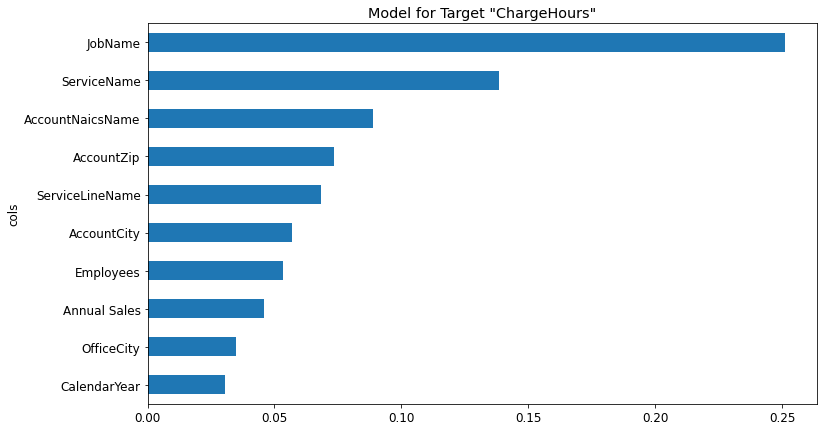

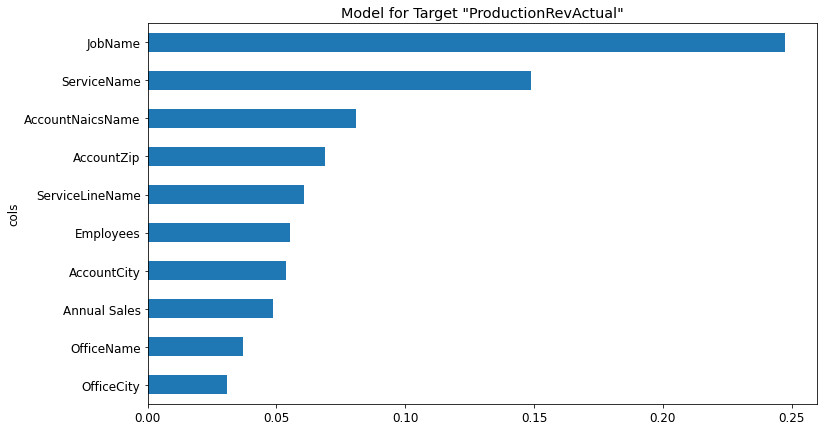

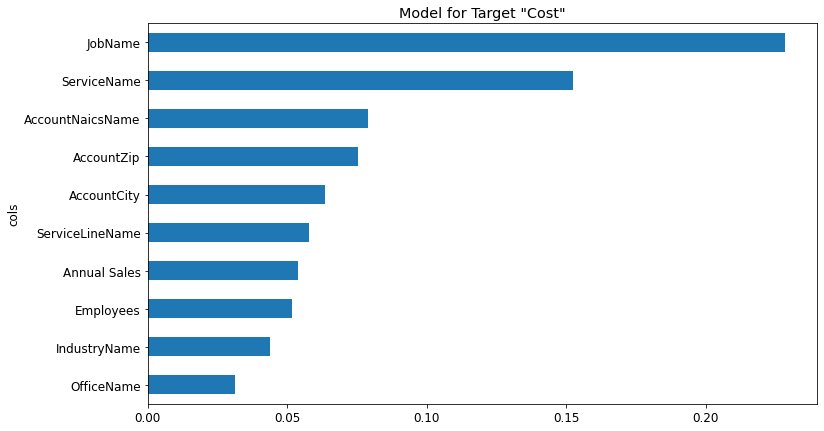

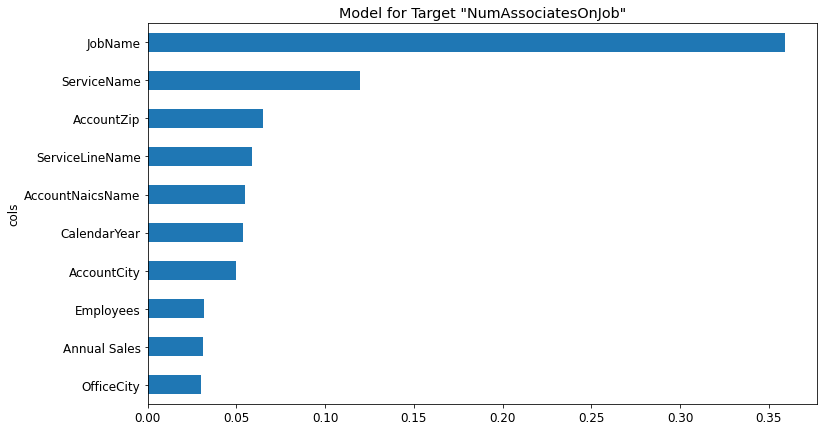

In [15]:

# plotting utility for feature importances from fastai
def plot_fi(fi,title, save=True):
    return fi.plot('cols', 'imp', 'barh', title=title, figsize=(12,7), legend=False)


# container for feature importances
fi_container = {}
# custom loop to get feature importances and output them using the convenience functiosn from fastai
for idx,m in enumerate(rf_base_models):
    train_X = dataloaders_by_tgt[idx][0]
    #print(train_X.shape)
    feature_importances = rf_feat_importance(m, train_X)
    
    fi_container[targets[idx]] = feature_importances
    #print(feature_importances.sort_values(ascending=False,by='imp')[:10])
    # plot top 10 feature importances
    plot_fi(feature_importances.sort_values(by='imp')[-10:], title = f'Model for Target \"{targets[idx]}\"')
    
  

<font color="purple"> in the above plots it looks like job name and service name are the clear best predictors, with some other features having decent contribution in certain cases </font>

---

## random forest, feature selection

lets try to simplify the model by using features which have a feature importance of at least 0.03

In [16]:
# *****************************************************************
# step 1: 
# fi_container contains key:values where key=name of target var, value=dataframe of feature importances sorted descending
cols_to_keep = [] # container to hold the colnames to keep for each model, sorted by idx of 'targets'
for k,v in fi_container.items():
    keeps = v[v.imp>0.03].cols
    cols_to_keep.append(keeps)
    print(f'keeping {len(keeps)} columns for model with target {k}')
print('*'*80)
# *****************************************************************
# step 2: save filtered datasets to dataloaders_by_tgt_filtered
# iterate over all targets and index into the containers
rf_with_fi_fs_rmses = {}
rf_with_fi_fs_feat_count = []
dataloaders_by_tgt_filtered = []
for idx,t in enumerate(targets):
    # unpack tuple
    xs,y,valid_xs,valid_y = dataloaders_by_tgt[idx]
    # filter cols
    xs_filtered = xs[cols_to_keep[idx]]
    valid_xs_filtered = valid_xs[cols_to_keep[idx]]
    print(f'target var {t}   ---   shape of xs {xs.shape}   ---   shape of filtered xs {xs_filtered.shape}')
    dataloaders_by_tgt_filtered.append((xs_filtered,y,valid_xs_filtered,valid_y))
print('*'*80)
# *****************************************************************
# step 3: test to see if the model got better using the rf convenience func
for idx,t in enumerate(targets):
    print(f'RF Model for {t} with {len(cols_to_keep[idx])} features')
    # fit model
    m = rf(dataloaders_by_tgt_filtered[idx][0], dataloaders_by_tgt_filtered[idx][1])
    # look at oob score
    print(f'OOB Score: {m.oob_score_}')
    preds = m.predict(dataloaders_by_tgt_filtered[idx][2])
    # numassociatesonjob
    rmse = mean_squared_error(dataloaders_by_tgt_filtered[idx][3], preds,squared=False)
    rf_with_fi_fs_rmses[t]=rmse
    rf_with_fi_fs_feat_count=len(cols_to_keep[idx])
    # convenience to access old results
    accessor = f'{t} pred stats (rmse,r2)' # to match the keys from 'results'
    # compare rmse
    print(f'New RMSE: {rmse:,.4f}, Old RMSE: {rf_base_results[accessor][0]}, Change (if neg, its an improvement): {rmse-rf_base_results[accessor][0]:,.4f}')
    # plot column cluster tree of similarity
    # cluster_columns(dataloaders_by_tgt_filtered[idx][0])
    print('*'*80)

keeping 10 columns for model with target ChargeHours
keeping 10 columns for model with target ProductionRevActual
keeping 11 columns for model with target Cost
keeping 10 columns for model with target NumAssociatesOnJob
********************************************************************************
target var ChargeHours   ---   shape of xs (28628, 20)   ---   shape of filtered xs (28628, 10)
target var ProductionRevActual   ---   shape of xs (28628, 20)   ---   shape of filtered xs (28628, 10)
target var Cost   ---   shape of xs (28628, 20)   ---   shape of filtered xs (28628, 11)
target var NumAssociatesOnJob   ---   shape of xs (28628, 20)   ---   shape of filtered xs (28628, 10)
********************************************************************************
RF Model for ChargeHours with 10 features
OOB Score: 0.2789972768540152
New RMSE: 48.7051, Old RMSE: 48.65751840214235, Change (if neg, its an improvement): 0.0476
**************************************************************

---

### after removing features, we can go back to the full data because of the minimal change

it might make sense to do some feature pruning for redundant features, so lets do that simply by looking at our tree diagrams again, but this time for all the features

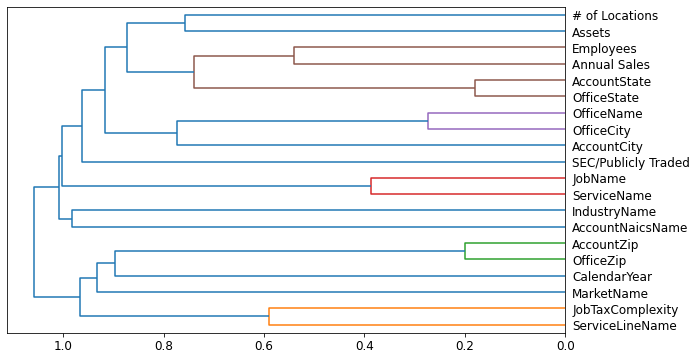

In [17]:
# because we are looking at essentiall the same full training set, we can just look at one plot
cluster_columns(dataloaders_by_tgt[0][0])

<font color="purple"> it looks like there are some similarities between a few different variables. veriables that are merged early (on the right side) above are done via rank correlation, per Howard &amp; Gugger (2020). So in our case AccountState and Office State, AccountZip and OfficeZip, and OfficeName and OfficeCity are the most redundant features. This is quite similar to the findings from our correlation analysis in our EDA work. So lets remove those features, the only difference we remove AccountState here instead of AccountCity. as below, this gives us 15 columns, which we can test again the random forest models on.</font>

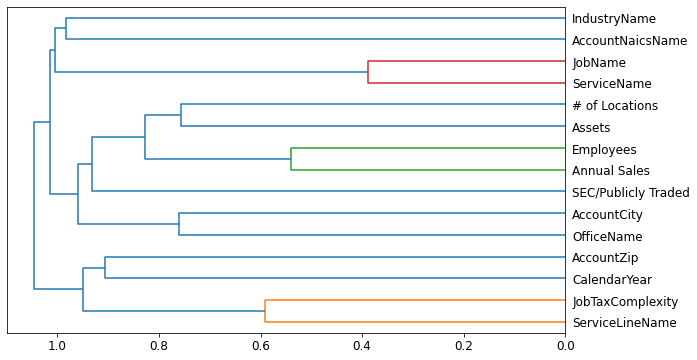

In [18]:
test = dataloaders_by_tgt[0][0].drop(columns=['OfficeState','OfficeCity','OfficeZip','AccountState','MarketName'])
cluster_columns(test)            

### retraining rf models on 15 features

In [19]:
# *****************************************************************
# step 1: 
# fi_container contains key:values where key=name of target var, value=dataframe of feature importances sorted descending
cols_to_drop = ['OfficeState','OfficeCity','OfficeZip','AccountState','MarketName']
# *****************************************************************
# step 2: save filtered datasets to dataloaders_by_tgt_filtered
# iterate over all targets and index into the containers
dataloaders_by_tgt_filtered = []
for idx,t in enumerate(targets):
    # unpack tuple
    xs,y,valid_xs,valid_y = dataloaders_by_tgt[idx]
    # filter cols
    xs_filtered = xs.drop(columns=cols_to_drop)
    valid_xs_filtered = valid_xs.drop(columns=cols_to_drop)
    print(f'target var {t}   ---   shape of xs {xs.shape}   ---   shape of filtered xs {xs_filtered.shape}')
    dataloaders_by_tgt_filtered.append((xs_filtered,y,valid_xs_filtered,valid_y))
print('*'*80)
# *****************************************************************
# step 3: test to see if the model got better using the rf convenience func
filtered_rf_rmses = {}
models_filtered_dfs = []
for idx,t in enumerate(targets):
    print(f'RF Model for {t} with {len(dataloaders_by_tgt_filtered[idx][0].columns)} features')
    # fit model
    m = rf(dataloaders_by_tgt_filtered[idx][0], dataloaders_by_tgt_filtered[idx][1])
    models_filtered_dfs.append(m)
    # look at oob score
    print(f'OOB Score: {m.oob_score_}')
    preds = m.predict(dataloaders_by_tgt_filtered[idx][2])
    # numassociatesonjob
    rmse = mean_squared_error(dataloaders_by_tgt_filtered[idx][3], preds,squared=False)
    filtered_rf_rmses[t] = rmse
    # convenience to access old results
    accessor = f'{t} pred stats (rmse,r2)' # to match the keys from 'results'
    # compare rmse
    print(f'New RMSE: {rmse:,.4f}, Old RMSE: {rf_base_results[accessor][0]}, Change (if neg, its an improvement): {rmse-rf_base_results[accessor][0]:,.4f}')
    # plot column cluster tree of similarity
    # cluster_columns(dataloaders_by_tgt_filtered[idx][0])
    print('*'*80)

target var ChargeHours   ---   shape of xs (28628, 20)   ---   shape of filtered xs (28628, 15)
target var ProductionRevActual   ---   shape of xs (28628, 20)   ---   shape of filtered xs (28628, 15)
target var Cost   ---   shape of xs (28628, 20)   ---   shape of filtered xs (28628, 15)
target var NumAssociatesOnJob   ---   shape of xs (28628, 20)   ---   shape of filtered xs (28628, 15)
********************************************************************************
RF Model for ChargeHours with 15 features
OOB Score: 0.2808919132685991
New RMSE: 48.4343, Old RMSE: 48.65751840214235, Change (if neg, its an improvement): -0.2233
********************************************************************************
RF Model for ProductionRevActual with 15 features
OOB Score: 0.2844319726978267
New RMSE: 9,363.1918, Old RMSE: 9381.848526900307, Change (if neg, its an improvement): -18.6568
********************************************************************************
RF Model for Cost with 

<font color="purple"> YAY! So we have made some improvement in two of the models, and not seen too adverse of effects in the other two. for a simpler model this exchange is well worth it.</font>

---

### now that we have a better feature set (smaller), lets look at tree interpreter 

this will help us to see the contributions from feature to each of our model targets

again, we are using fastai's guidance and the treeinterpreter/waterfallcharts packages

In [20]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

Model for target: ChargeHours
Prediction: [0.50008466], Bias: 20.223514985414425, Sum Of Contribs: -19.723430325858544


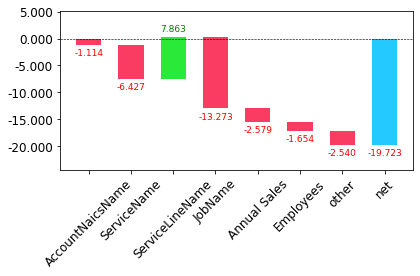

********************************************************************************
Model for target: ProductionRevActual
Prediction: [56.73222865], Bias: 4184.97596016035, Sum Of Contribs: -4128.243731513991


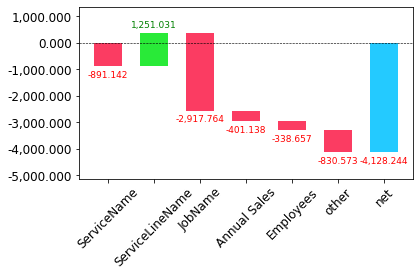

********************************************************************************
Model for target: Cost
Prediction: [34.04854634], Bias: 939.0134932452892, Sum Of Contribs: -904.9649469036746


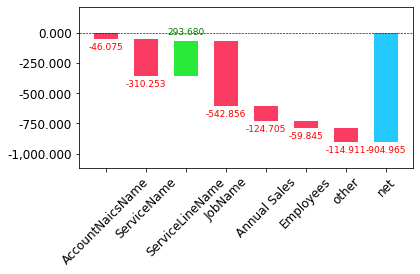

********************************************************************************
Model for target: NumAssociatesOnJob
Prediction: [2.53223392], Bias: 3.5221545340226346, Sum Of Contribs: -0.9899206135195742


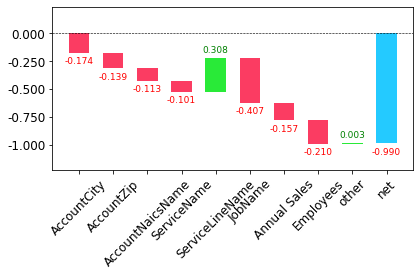

********************************************************************************


In [21]:
# *****************************************************************
for idx,t in enumerate(targets):
    print(f'Model for target: {t}')
    # step 1: iterate over models and get the first few rows
    # using the validation set from the filtered data where idx = the model index, 
    # and 2 is the 3rd element in the tuple (xs_filtered,y,valid_xs_filtered,valid_y)
    row = dataloaders_by_tgt_filtered[idx][2].iloc[:5]
    # *****************************************************************
    # step 2: get prediction, bias, contribution from treeinterpreter for each model and set of row values
    # using the model trained on the filtered dataframe
    prediction,bias,contributions = treeinterpreter.predict(models_filtered_dfs[idx], row.values)
    # *****************************************************************
    # step 3: view the prediction, contribution, and bias of the first row in each models validation data
    print(f'Prediction: {prediction[0]}, Bias: {bias[0]}, Sum Of Contribs: {contributions[0].sum()}')
    # *****************************************************************
    # step 4: look at the contribution for the first row in the validation data via a waterfall plot 
    # showing the relative contributions to the final pred for each model
    waterfall(dataloaders_by_tgt_filtered[idx][2].columns, contributions[0], threshold=0.08, 
              rotation_value=45,formatting='{:,.3f}')
    plt.show()
    print('*'*80)

<font color="purple"> in short, the contributions demonstrate the relative impact of each variable on the outcome 'net' </font>

---

## Can we do bettter with XgBoost?

we will try this on our filtered set of 15 features for each of our targets, so 4 models in total

In [22]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import time
from scipy.stats import uniform, randint
# using XGBRegressor, could also try XGBRFRegressor which uses a random forest implementation

In [23]:
# use our filtered dataloaders
#dataloaders_by_tgt_filtered
filtered_rf_rmses

{'ChargeHours': 48.434262537826186,
 'ProductionRevActual': 9363.191750882717,
 'Cost': 2085.0549581288415,
 'NumAssociatesOnJob': 2.170539793423609}

In [24]:
print('*'*80)
# *****************************************************************
# step 3: test to see if the model got better using the rf convenience func
xgb_rmses = {}
xgb_models = []
for idx,t in enumerate(targets):
    print(f'RF Model for {t} with {len(dataloaders_by_tgt_filtered[idx][0].columns)} features')
    # instsantiate and fit model
    xgb_regr = xgb.XGBRegressor()
    # instantiate params dict for randomized search
    params = {
    "learning_rate": [0.001, 0.01, 0.1, 0.5, 1.],
    "max_depth": randint(1, 10),
    "n_estimators": randint(10, 150),
    "subsample": uniform(0.05, 0.95),  # so uniform on [.05,.05+.95] = [.05,1.]
    "min_child_weight": randint(1, 20),
    "reg_alpha": uniform(0, 5),
    "reg_lambda": uniform(0, 5),
    "tree_method": ['hist'] # trying hist method because its said to work well with 
    }
    # time the randomized search
    start = time.time()
    xgb_rs = RandomizedSearchCV(xgb_regr,param_distributions=params,random_state=42,
                                n_iter=25,cv=5,verbose=1,n_jobs=-1,return_train_score=True)
    xgb_rs.fit(dataloaders_by_tgt_filtered[idx][0], dataloaders_by_tgt_filtered[idx][1])
    end = time.time()
    delta = end - start
    print(f"took {delta:.2f} seconds to perform randomized search")
    print(f'best params: {xgb_rs.best_params_}')
    # train final model
    xgb_best_params = xgb.XGBRegressor(random_state=42, n_jobs=-1,**xgb_rs.best_params_)
    m = xgb_best_params.fit(dataloaders_by_tgt_filtered[idx][0], dataloaders_by_tgt_filtered[idx][1])
    xgb_models.append(m)
    preds = m.predict(dataloaders_by_tgt_filtered[idx][2])
    # numassociatesonjob
    rmse = mean_squared_error(dataloaders_by_tgt_filtered[idx][3], preds,squared=False)
    xgb_rmses[t] = rmse
    # compare rmse
    print(f'New RMSE: {rmse:,.4f}, RF Filtered RMSE: {filtered_rf_rmses[t]}, Change (if neg, its an improvement): {rmse-filtered_rf_rmses[t]:,.4f}')
    print('*'*80)

********************************************************************************
RF Model for ChargeHours with 15 features
Fitting 5 folds for each of 25 candidates, totalling 125 fits
took 26.74 seconds to perform randomized search
best params: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 7, 'n_estimators': 138, 'reg_alpha': 1.1396758127097084, 'reg_lambda': 2.1355389431312815, 'subsample': 0.8271140276263684, 'tree_method': 'hist'}
New RMSE: 49.2210, RF Filtered RMSE: 48.434262537826186, Change (if neg, its an improvement): 0.7867
********************************************************************************
RF Model for ProductionRevActual with 15 features
Fitting 5 folds for each of 25 candidates, totalling 125 fits
took 23.60 seconds to perform randomized search
best params: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 99, 'reg_alpha': 2.560465291496405, 'reg_lambda': 1.1324788759896898, 'subsample': 0.6629141508889774, 'tree_method

In [25]:
np.random.seed(42)
from GPyOpt.methods import BayesianOptimization
from sklearn.model_selection import cross_val_score, KFold
# USING TEMPLATE CODE FROM DS775 HOMEWORK 8
hp_bounds = [
    {'name': 'learning_rate','type': 'continuous','domain': (0.001, 1.0)}, 
    {'name': 'max_depth','type': 'discrete','domain': (1, 10)}, 
    {'name': 'n_estimators','type': 'discrete','domain': (10, 150)}, 
    {'name': 'subsample','type': 'continuous','domain': (0.05, 1.0)}, 
    {'name': 'min_child_weight','type': 'discrete','domain': (1, 20)}, 
    {'name': 'reg_alpha','type': 'continuous','domain': (0, 5)}, 
    {'name': 'reg_lambda','type': 'continuous','domain': (0, 5)}]

xgb_bayopt_models = []
xgb_bayopt_rmses = {}
xgb_bayopt_hyperparamter_sets = []
for idx,t in enumerate(targets):
    print(f'XGB Model with Bayesian Optimization for {t} with {len(dataloaders_by_tgt_filtered[idx][0].columns)} features')
    # time the randomized search
    start = time.time()
    # Optimization objective
    def cv_score(hyp_parameters):
        hyp_parameters = hyp_parameters[0]
        xgb_model = xgb.XGBRegressor(objective='reg:squarederror',learning_rate=hyp_parameters[0],
                                     max_depth=int(hyp_parameters[1]),n_estimators=int(hyp_parameters[2]),
                                     subsample=hyp_parameters[3],min_child_weight=int(hyp_parameters[4]),
                                     reg_alpha=hyp_parameters[5],reg_lambda=hyp_parameters[6])
        
        scores = cross_val_score(xgb_model, X=dataloaders_by_tgt_filtered[idx][0],
                                 y=dataloaders_by_tgt_filtered[idx][1],cv=KFold(n_splits=5))
        return np.array(scores.mean())  # return average of 5-fold scores

    optimizer = BayesianOptimization(f=cv_score,domain=hp_bounds,model_type='GP',acquisition_type='EI',
                                     acquisition_jitter=0.05,exact_feval=True,maximize=True,verbosity=False)
    optimizer.run_optimization(max_iter=20,verbosity=True)
    # ----------------- get best hyperparamters ---------------------
    best_hyp_set = {}
    for i in range(len(hp_bounds)):
        if hp_bounds[i]['type'] == 'continuous':
            best_hyp_set[hp_bounds[i]['name']] = optimizer.x_opt[i]
        else:
            best_hyp_set[hp_bounds[i]['name']] = int(optimizer.x_opt[i])
    xgb_bayopt_hyperparamter_sets.append(best_hyp_set)

    end = time.time()
    delta = end - start
    print(f"took {delta:.2f} seconds to perform bayesian optimization")
    print(f'best params: {best_hyp_set}')
    # train final model
    bayopt_search = xgb.XGBRegressor(objective='reg:squarederror',**best_hyp_set)
    m = bayopt_search.fit(dataloaders_by_tgt_filtered[idx][0], dataloaders_by_tgt_filtered[idx][1])
    xgb_bayopt_models.append(m)
    preds = m.predict(dataloaders_by_tgt_filtered[idx][2])
    # numassociatesonjob
    rmse = mean_squared_error(dataloaders_by_tgt_filtered[idx][3], preds,squared=False)
    xgb_bayopt_rmses[t] = rmse
    # compare rmse
    print(f'New RMSE: {rmse:,.4f}, RF Filtered RMSE: {filtered_rf_rmses[t]}, Change (if neg, its an improvement): {rmse-filtered_rf_rmses[t]:,.4f}')
    print('*'*80)

XGB Model with Bayesian Optimization for ChargeHours with 15 features
num acquisition: 1, time elapsed: 2.70s
num acquisition: 2, time elapsed: 4.42s
num acquisition: 3, time elapsed: 6.07s
num acquisition: 4, time elapsed: 7.80s
num acquisition: 5, time elapsed: 9.66s
num acquisition: 6, time elapsed: 11.75s
num acquisition: 7, time elapsed: 13.57s
num acquisition: 8, time elapsed: 14.87s
num acquisition: 9, time elapsed: 26.87s
num acquisition: 10, time elapsed: 28.46s
num acquisition: 11, time elapsed: 29.14s
num acquisition: 12, time elapsed: 35.46s
num acquisition: 13, time elapsed: 35.86s
num acquisition: 14, time elapsed: 36.54s
num acquisition: 15, time elapsed: 38.34s
num acquisition: 16, time elapsed: 39.33s
num acquisition: 17, time elapsed: 52.70s
num acquisition: 18, time elapsed: 53.37s
num acquisition: 19, time elapsed: 54.26s
num acquisition: 20, time elapsed: 54.85s
took 61.02 seconds to perform bayesian optimization
best params: {'learning_rate': 1.0, 'max_depth': 1, 

<font color="purple">So XGBoost doesn\'t seem to make much of a difference, in fact it is worse than a random forest model. interesting</font>

---


# <font color="blue">Neural Net</font>

<font color="blue">now that we've run through the random forest modeling pretty thoroughly, lets try a neural network. we can check performance versus random forest and xgb, but more importantly this will allow us to use entity embeddings from the neural net as inputs to an xgboost model.</font>


first though, we will replicate the setup steps from above so we start with a clean slate

In [26]:
# ******************************************************************************************
# reload data
df = pd.read_csv('./data/clean_data.csv', low_memory=False)

# ******************************************************************************************
# declare cols
cats = ['CalendarYear', 'OfficeCity', 'OfficeState', 'OfficeZip', 'OfficeName',
       'AccountCity', 'AccountState', 'AccountZip', 'AccountNaicsName',
       'MarketName', 'ServiceName', 'ServiceLineName', 'IndustryName',
       'JobName','SEC/Publicly Traded']
ords = ['JobTaxComplexity','Annual Sales','Assets', 'Employees']
numerics = ['# of Locations']
targets = ['ChargeHours', 'ProductionRevActual',
       'Cost', 'NumAssociatesOnJob']
df = df[cats+ords+numerics+targets]


# ******************************************************************************************
# define our orders. note that money_ords is used twice in the dict(zip()) below
money_ords = ['Unknown','Under $200K','$200K - $499K','$500K - $999K','1M - 2.4M','2.5M - 4.9M','5M - 9.9M'
                         ,'10M - 24.9M','25M - 49M','50M - 99M','100M - 249M','250M - 499M','500M - 749M'
                         ,'750M - 999M','1B - 1.49B','1.5B - 1.9B','2B +']
emp_ords = ['Unknown', '1 - 9', '10 - 24', '25 - 49', '50 - 99', '100 - 249', '250 - 499', '500 - 999', '1,000 - 2,499'
                         , '2,500 - 4,999', '5,000 - 9,999', '10,000 - 14,999', '15,000 - 19,999','20,000 +']

jt_complex_ords = ['Not Applicable', 'Basic', 'Intermediate', 'Complex']
# ******************************************************************************************
# create our ordinal column:orderedvalue mapping
col_order_dict = dict(zip(ords,[jt_complex_ords,money_ords, money_ords, emp_ords]))
#col_order_dict
# ******************************************************************************************
# set values
for col in ords:
    # set astype category
    df[col] = df[col].astype('category')
    # grab order list and pass it to set_categories
    df[col] = df[col].cat.set_categories(col_order_dict[col], ordered=True)
    
# ******************************************************************************************

In [27]:
# ref: https://github.com/fastai/fastai/blob/master/fastai/metrics.py
# ref2:
from fastai.metrics import _rmse # importing the metric class for use in the callback
def nn_wrapper(df_nn, cont_nn, cat_nn, dep_var, nn_layers = [500,250], comp_rmse = 0., comp_rmse_arch='RF'):
    print(f'NN Model for target {dep_var}')
    # ----- set model name 
    model_name = f'nn_{dep_var}'
    print(f'model_name: {model_name}')
    # -------------------------------------
    procs_nn = [Categorify, FillMissing, Normalize]
    to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                          splits=RandomSplitter(valid_pct=0.2, seed=42)(range_of(df_nn))
                          , y_names=dep_var)
    dls = to_nn.dataloaders(1024)
    # -------------------------------------
    
    # create learner
    y = to_nn.train.y # just to get yraange when instnatiating our learner
    # create callback to track our best model
    best_model_callback = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=model_name+'_bestM')] # using model name from early in the func
    learn = tabular_learner(dls, y_range=(round(y.min(),0)*0.9,round(y.max(),0)*1.1), layers=nn_layers,
                         loss_func=F.mse_loss, metrics=_rmse, cbs=best_model_callback)
    
    # # save the namedTuple optimal learning rate
    optimal_lr = learn.lr_find()
    print(f'Optimal Learning Rate: {optimal_lr[0]}')
    learn.fit_one_cycle(20,optimal_lr[0])#, wd=1e-2) # pass LR to fit, use wd of 1e-1 or 1e-2 (fastai default)

    preds,targs = learn.get_preds()
    rmse = mean_squared_error(targs,preds,squared=False)
    print("RMSE:", rmse)
    r2 = r2_score(targs, preds)
    print("R2:", r2)
    print(f'Comp rmse arch: {comp_rmse_arch}, rmse: {comp_rmse}\tDiff(negative = better): {rmse-comp_rmse}')

    print('*'*80)
    
    return model_name, dls, learn, to_nn

In [28]:
# get columns
targets = ['ChargeHours','ProductionRevActual','Cost','NumAssociatesOnJob']
features = [col for col in df.columns.tolist() if col not in targets]
len(features),len(targets)

(20, 4)

In [29]:
cont_nn,cat_nn = cont_cat_split(df[features], max_card=9000, dep_var=targets[0])
#cont_nn, cat_nn

In [30]:
# convert our targets to floats if not already
d = dict(df[targets].dtypes)
print(d)
for k,v in d.items():
    if df[k].dtype!= np.float:
        df = df.astype({k:np.float64})
    #print(df[k].dtype, df[k].dtype!= np.float)
#print(d[targets[0]] == np.int,d[targets[1]] == np.integer,d[targets[2]] == np.int,d[targets[3]] != np.float)
df[targets].dtypes

{'ChargeHours': dtype('float64'), 'ProductionRevActual': dtype('float64'), 'Cost': dtype('float64'), 'NumAssociatesOnJob': dtype('int64')}


ChargeHours            float64
ProductionRevActual    float64
Cost                   float64
NumAssociatesOnJob     float64
dtype: object

****************NEURAL NET MODELS****************
*************************************************
*	started: 2022-04-18 11:43:13.272202	*
*************************************************
NN Model for target ChargeHours
model_name: nn_ChargeHours


Optimal Learning Rate: 0.001737800776027143


epoch,train_loss,valid_loss,_rmse,time
0,1314251.000000,1248102.875000,1117.185181,00:02
1,1252461.500000,1170593.000000,1081.939209,00:02
2,1073914.750000,596079.312500,772.055298,00:02
3,697939.250000,79035.382812,281.127258,00:02
4,401714.750000,18030.425781,134.262772,00:02
5,232042.203125,11647.029297,107.898369,00:02
6,135661.140625,6902.691406,83.021317,00:02
7,80051.171875,5693.622070,75.272263,00:02
8,47800.707031,5672.794922,74.724335,00:02
9,29045.597656,5603.483887,73.202637,00:02


Better model found at epoch 0 with _rmse value: 1117.1851806640625.
Better model found at epoch 1 with _rmse value: 1081.939208984375.
Better model found at epoch 2 with _rmse value: 772.0552978515625.
Better model found at epoch 3 with _rmse value: 281.12725830078125.
Better model found at epoch 4 with _rmse value: 134.2627716064453.
Better model found at epoch 5 with _rmse value: 107.89836883544922.
Better model found at epoch 6 with _rmse value: 83.02131652832031.
Better model found at epoch 7 with _rmse value: 75.27226257324219.
Better model found at epoch 8 with _rmse value: 74.72433471679688.
Better model found at epoch 9 with _rmse value: 73.20263671875.
Better model found at epoch 10 with _rmse value: 61.38405990600586.
Better model found at epoch 11 with _rmse value: 57.9231071472168.
Better model found at epoch 12 with _rmse value: 57.568031311035156.
Better model found at epoch 14 with _rmse value: 52.46697235107422.


RMSE: 52.536293
R2: 0.21079113943992134
Comp rmse arch: RandomForest, rmse: 48.434262537826186	Diff(negative = better): 4.1020304919589705
********************************************************************************
*************************************************
*	ended: 2022-04-18 11:44:07.710890	*
*	elapsed time: 0:00:54.438688		*
*************************************************
*************************************************
*	started: 2022-04-18 11:44:07.710890	*
*************************************************
NN Model for target ProductionRevActual
model_name: nn_ProductionRevActual


Optimal Learning Rate: 0.0014454397605732083


epoch,train_loss,valid_loss,_rmse,time
0,35939815424.000000,44683034624.000000,211382.906250,00:02
1,30253135872.000000,86003367936.000000,293262.750000,00:02
2,23231506432.000000,15761309696.000000,125512.218750,00:02
3,16279371776.000000,5605295616.000000,74699.875000,00:02
4,11432763392.000000,3153806080.000000,56024.441406,00:02
5,8121056256.000000,2768594944.000000,52543.808594,00:02
6,5956926976.000000,1542869376.000000,39068.660156,00:02
7,4447173120.000000,1103672704.000000,32907.019531,00:02
8,4182392832.000000,3375083264.000000,57875.789062,00:02
9,3366326528.000000,1705123072.000000,41066.160156,00:02


Better model found at epoch 0 with _rmse value: 211382.90625.
Better model found at epoch 2 with _rmse value: 125512.21875.
Better model found at epoch 3 with _rmse value: 74699.875.
Better model found at epoch 4 with _rmse value: 56024.44140625.
Better model found at epoch 5 with _rmse value: 52543.80859375.
Better model found at epoch 6 with _rmse value: 39068.66015625.
Better model found at epoch 7 with _rmse value: 32907.01953125.
Better model found at epoch 13 with _rmse value: 28028.85546875.
Better model found at epoch 14 with _rmse value: 27350.318359375.
Better model found at epoch 15 with _rmse value: 26943.642578125.


RMSE: 27331.043
R2: -4.765254699896691
Comp rmse arch: RandomForest, rmse: 9363.191750882717	Diff(negative = better): 17967.851217867283
********************************************************************************
*************************************************
*	ended: 2022-04-18 11:45:00.410737	*
*	elapsed time: 0:00:52.699847		*
*************************************************
*************************************************
*	started: 2022-04-18 11:45:00.410737	*
*************************************************
NN Model for target Cost
model_name: nn_Cost


Optimal Learning Rate: 0.0020892962347716093


epoch,train_loss,valid_loss,_rmse,time
0,1918359680.000000,2561477632.000000,50610.820312,00:02
1,1567882112.000000,4796132864.000000,69253.921875,00:02
2,1130990080.000000,692510272.000000,26300.175781,00:02
3,752951808.000000,276619456.000000,16596.132812,00:02
4,514266144.000000,115434600.000000,10690.451172,00:02
5,350427872.000000,49238232.000000,6933.846680,00:02
6,237338240.000000,38966004.000000,6148.305176,00:02
7,165428096.000000,28624790.000000,5242.660645,00:02
8,118824192.000000,83517352.000000,9118.324219,00:02
9,92022984.000000,41854884.000000,6380.255859,00:02


Better model found at epoch 0 with _rmse value: 50610.8203125.
Better model found at epoch 2 with _rmse value: 26300.17578125.
Better model found at epoch 3 with _rmse value: 16596.1328125.
Better model found at epoch 4 with _rmse value: 10690.451171875.
Better model found at epoch 5 with _rmse value: 6933.8466796875.
Better model found at epoch 6 with _rmse value: 6148.30517578125.
Better model found at epoch 7 with _rmse value: 5242.66064453125.
Better model found at epoch 11 with _rmse value: 4887.38623046875.
Better model found at epoch 14 with _rmse value: 4220.09814453125.
Better model found at epoch 16 with _rmse value: 4119.84521484375.
Better model found at epoch 17 with _rmse value: 3850.892333984375.
Better model found at epoch 18 with _rmse value: 3837.5224609375.


RMSE: 4001.8872
R2: -1.4952745312753377
Comp rmse arch: RandomForest, rmse: 2085.0549581288415	Diff(negative = better): 1916.8322489024085
********************************************************************************
*************************************************
*	ended: 2022-04-18 11:45:52.625247	*
*	elapsed time: 0:00:52.214510		*
*************************************************
*************************************************
*	started: 2022-04-18 11:45:52.625247	*
*************************************************
NN Model for target NumAssociatesOnJob
model_name: nn_NumAssociatesOnJob


Optimal Learning Rate: 0.002511886414140463


epoch,train_loss,valid_loss,_rmse,time
0,302.545593,459.238892,21.429647,00:02
1,238.511139,812.970093,28.512428,00:02
2,166.215103,113.671997,10.655829,00:02
3,110.510941,28.095692,5.276334,00:02
4,73.563942,15.696022,3.948102,00:02
5,50.159565,11.997701,3.454398,00:02
6,34.231567,9.988864,3.144762,00:02
7,29.294439,25.845818,5.078086,00:02
8,22.892939,10.742032,3.260123,00:02
9,17.755327,9.144103,3.006806,00:02


Better model found at epoch 0 with _rmse value: 21.42964744567871.
Better model found at epoch 2 with _rmse value: 10.655829429626465.
Better model found at epoch 3 with _rmse value: 5.276334285736084.
Better model found at epoch 4 with _rmse value: 3.94810152053833.
Better model found at epoch 5 with _rmse value: 3.454397678375244.
Better model found at epoch 6 with _rmse value: 3.144761800765991.
Better model found at epoch 9 with _rmse value: 3.006805896759033.
Better model found at epoch 10 with _rmse value: 2.7338476181030273.
Better model found at epoch 12 with _rmse value: 2.675893783569336.
Better model found at epoch 13 with _rmse value: 2.608741044998169.
Better model found at epoch 14 with _rmse value: 2.605710029602051.
Better model found at epoch 16 with _rmse value: 2.600482702255249.
Better model found at epoch 19 with _rmse value: 2.58302640914917.


RMSE: 2.5941062
R2: 0.21444577604423232
Comp rmse arch: RandomForest, rmse: 2.170539793423609	Diff(negative = better): 0.4235664039335689
********************************************************************************
*************************************************
*	ended: 2022-04-18 11:46:46.274190	*
*	elapsed time: 0:00:53.648943		*
*************************************************


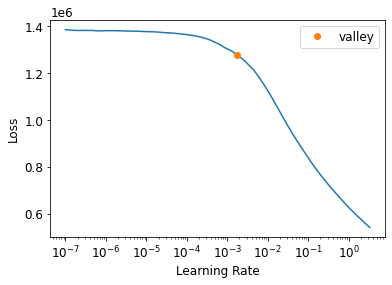

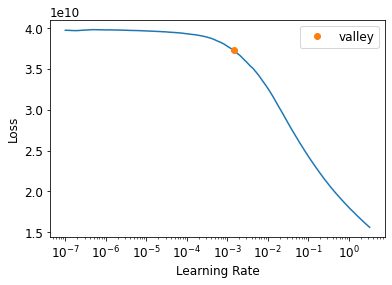

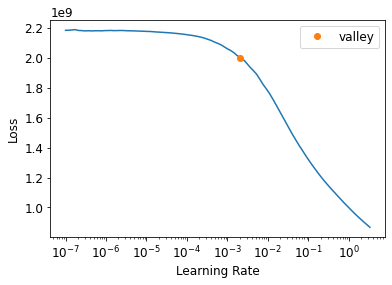

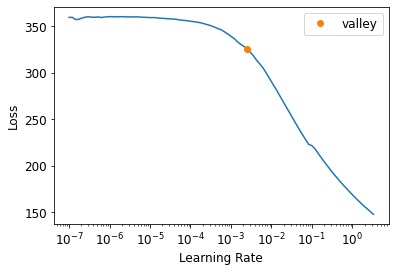

In [31]:
m_names = [] # names of the model(s)
dls_from_nn = [] # dataloaders object
learners = [] # the learner object
tblr_pandas = [] # tabular pandas object

to_cont = []
to_cat = ['OfficeZip']
print('****************NEURAL NET MODELS****************')
for t in targets:
    start = dt.datetime.now()
    print('*'*49)
    print(f'*\tstarted: {start}\t*')
    print('*'*49)
    # split our var types
    cont_nn,cat_nn = cont_cat_split(df[features], max_card=9000, dep_var=t)
    # swap categories to continous if we have some : manual overrids
    if len(to_cont) > 0:
        for c in to_cont:
            cont_nn.append(c)
            cat_nn.remove(c)
    # swap contious to categoricals if we have some : manual overrides
    if len(to_cat) > 0:
        for c in to_cat:
            cat_nn.append(c)
            cont_nn.remove(c)
    # run a model
    # first, if we are looking at NumAssociatesOnJob as the target (idx 3), we want to convert to different precision
    #if t = 'NumAssociatesOnJob'   
    model_name, dls, arch, tblr_pd = nn_wrapper(df_nn=df, cont_nn=cont_nn, cat_nn=cat_nn, dep_var=t ,nn_layers= [500,250], comp_rmse=filtered_rf_rmses[t], comp_rmse_arch='RandomForest')
    # save outputs
    m_names.append(model_name)
    dls_from_nn.append(dls)
    learners.append(arch)
    tblr_pandas.append(tblr_pd)
    
    print('*'*49)
    end = dt.datetime.now()
    print(f'*\tended: {end}\t*')
    print(f'*\telapsed time: {(end-start)}\t\t*')
    print('*'*49)

In [32]:
best_nn_model_rmses = []
for idx,lrn in enumerate(learners):
    learn = lrn.load(m_names[idx]+'_bestM')
    preds,targs = learn.get_preds()
    nn_preds=  preds.squeeze(1)
    best_nn_model_rmses.append(_rmse(preds, targs))
    print(f'RMSE for model with target {targets[idx]}: {_rmse(preds, targs)}')

RMSE for model with target ChargeHours: 52.53629684448242


RMSE for model with target ProductionRevActual: 27331.04296875


RMSE for model with target Cost: 4001.88720703125


RMSE for model with target NumAssociatesOnJob: 2.5941061973571777


In [33]:
print(f'RF Rmses for comparison:\n{filtered_rf_rmses}')

RF Rmses for comparison:
{'ChargeHours': 48.434262537826186, 'ProductionRevActual': 9363.191750882717, 'Cost': 2085.0549581288415, 'NumAssociatesOnJob': 2.170539793423609}


<font color="purple"> As we can see there is no measured improvement with a basic neural net, over the RF (or even XGB) approaches. This suggests that maybe we can gain some information leveraging embeddings, but the neural net probably isn't yielding the results we want unless we go deeper and or train more parameters. That said, based on the loss it seems like we might be at risk of overfitting if we go that route.</font>

---


# Random Forest, XGB With Embeddings from Neural Net

we will now extract, for each of our models, the embeddings for the categorical variables to use in place of the features themselves. As shown by Guo (2016), entinty embeddings can provide more information than one-hot encoding because they capture the relationship between categorical levels by borrowing techniques from NLP methodologies

we found a helper function to extract the embeddings here <a href="https://towardsdatascience.com/using-entity-embeddings-to-improve-the-performance-of-machine-learning-models-7bf35e9a7822#:~:text=The%20general%20steps%20to%20using%20embeddings%20learned%20by,Extract%20the%20embeddings%20from%20the%20trained%20neural%20network">Jia Qing's blog post on using embeddings at Towards Data Science (Medium)</a>

In [34]:
# source for this helper func: https://towardsdatascience.com/using-entity-embeddings-to-improve-the-performance-of-machine-learning-models-7bf35e9a7822#:~:text=The%20general%20steps%20to%20using%20embeddings%20learned%20by,Extract%20the%20embeddings%20from%20the%20trained%20neural%20network.

def embedings_as_features(learner, df):
    df =df.copy()
    for idx, feature in enumerate(learner.dls.cat_names):
        emb = learner.model.embeds[idx]
        new_feature = pd.DataFrame(emb(tensor(df[feature],dtype=torch.int64))
                                   ,index=df.index
                                   ,columns=[f'{feature}_{j}' for j in range(emb.embedding_dim)])
        df.drop(columns=feature, inplace=True)
        df = df.join(new_feature)
    return df

In [35]:
# train a model for each of our targets, using the embeddings from each of our neural nets (for the targets)
import xgboost as xgb
np.random.seed(123)
#m_names
#learners
#tblr_pandas
#dls_from_nn

emb_model_rf = []
emb_model_xgb = []

emb_rmse_rf = {}
emb_rmse_xgb = {}

emb_nf = []

print('****************RF AND XGB EMBEDDING MODELS****************')
for idx,lrn in enumerate(learners):
    start = dt.datetime.now()
    print('*'*49)
    print(f'*\tstarted: {start}\t*')
    print('*'*49)
    print(f'XGB and RF models with target {targets[idx]} using embeddings from model {m_names[idx]}')
    # ----------------------------------------------------------------------------------------------------------
    # get best learner
    learn = lrn.load(m_names[idx]+'_bestM')
    # get our dataloaders object
    dls = dls_from_nn[idx]
    # to train another model with embeddings we need the dataloaders pulled out
    X_train, y_train = dls.train.xs, dls.train.ys.values.ravel()
    X_valid, y_valid = dls.valid.xs, dls.valid.ys.values.ravel()
    # ----------------------------------------------------------------------------------------------------------
    # then we can convert our categoricals to embeddings using the helper function previously defined
    X_train_emb = embedings_as_features(learn, X_train)
    X_valid_emb = embedings_as_features(learn, X_valid)
    print(f'Original training data shape (rows,cols): {X_train.shape}\nData shape with Embeddings (rows,cols): {X_train_emb.shape}')
    print(f'Number of new features (excl 1 for 1 replacements): {X_train_emb.shape[1]-X_train.shape[1]}')
    emb_nf.append(X_train_emb.shape[1])
    # ----------------------------------------------------------------------------------------------------------
    print('-'*40)
    print('RF Model Baseline:')
    # fit model using random forest convenience function from way before in this notebook
    m = rf(X_train_emb, y_train)
    emb_model_rf.append(m)
    # look at oob score
    print(f'OOB Score: {m.oob_score_}')
    preds = m.predict(X_valid_emb)
    rmse = mean_squared_error(y_valid, preds,squared=False)
    emb_rmse_rf[targets[idx]] = rmse
    # ----------------------------------------------------------------------------------------------------------
    print('-'*40)
    print('XGB Model Baseline:')
    xgb_regr = xgb.XGBRegressor(random_state=42)
    xgb_regr.fit(X_train_emb,y_train)
    emb_model_xgb.append(xgb_regr)
    xgb_preds = tensor(xgb_regr.predict(X_valid_emb))
    rmse_xgb = mean_squared_error(xgb_preds, y_valid, squared=False)
    emb_rmse_xgb[targets[idx]]=rmse_xgb
    
    # ----------------------------------------------------------------------------------------------------------
    print('-'*40)
    print(f'Emb RF Model RMSE: {rmse}')
    print(f'Emb XGB Model RMSE: {rmse_xgb}')
    print(f'Orignal RF Model RMSE: {filtered_rf_rmses[targets[idx]]}')
    # ----------------------------------------------------------------------------------------------------------
    print('*'*49)
    end = dt.datetime.now()
    print(f'*\tended: {end}\t*')
    print(f'*\telapsed time: {(end-start)}\t\t*')
    print('*'*49)
    # ----------------------------------------------------------------------------------------------------------
    print('*'*80)

****************RF AND XGB EMBEDDING MODELS****************
*************************************************
*	started: 2022-04-18 11:46:48.110610	*
*************************************************
XGB and RF models with target ChargeHours using embeddings from model nn_ChargeHours
Original training data shape (rows,cols): (28628, 20)
Data shape with Embeddings (rows,cols): (28628, 779)
Number of new features (excl 1 for 1 replacements): 759
----------------------------------------
RF Model Baseline:
OOB Score: 0.30693079615923924
----------------------------------------
XGB Model Baseline:
----------------------------------------
Emb RF Model RMSE: 50.88018263908794
Emb XGB Model RMSE: 54.39141845703125
Orignal RF Model RMSE: 48.434262537826186
*************************************************
*	ended: 2022-04-18 11:52:28.573838	*
*	elapsed time: 0:05:40.463228		*
*************************************************
**********************************************************************

---

# <font color="red">Our final model class: Random Forest</font>

The preceding work determined that a Random Forest is indeed our best model. For some reason, the XGB and NN don't perform as well on the validation/test set, nor do the embeddings work well. It is best to proceed with the 15 feature (from feature selection) RandomForest model, but test out some optimization techniques for hypterparameter tuning to see if that improves outcomes.

### Randomized Search with Cross Validation

We reuse our filtered dataloaders from earlier in the notebook, which contain a list of rank 4 tuples of (train_x, train_y, valid_x, valid_y), one tuple per model, and we have one model per target

In [36]:
#dataloaders_by_tgt_filtered
targets

['ChargeHours', 'ProductionRevActual', 'Cost', 'NumAssociatesOnJob']

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

# function to plot regression results, adapted from ds775 project code

def plot_model_results(model, test_x, test_y, method_name, comp_rmse=0.):
    score_test = model.score(test_x,test_y)
    print(f'R^2 on Test: {score_test:.4f}')

    y_pred = model.predict(test_x)
    plt.plot(test_y,y_pred,'k.')
    plt.xlabel('Test Values')
    plt.ylabel('Predicted Values');
    
    rmse = mean_squared_error(test_y,y_pred, squared=False)
    print(f'New RMSE on test({method_name}): {rmse:,.4f}')
    print(f'Old RMSE on test (RF): {comp_rmse}')
    print(f'RMSE Change (if neg, its an improvement): {rmse-comp_rmse:.4f}')
    return rmse

**************************RF WITH RAND SEARCH CV MODELS**************************
*************************************************
*	started: 2022-04-18 12:02:18.730906	*
*************************************************
RF model with target "ChargeHours"
RF Model for ChargeHours with 15 features
Fitting 5 folds for each of 25 candidates, totalling 125 fits
took 130.61 seconds to perform randomized search
best params: {'bootstrap': True, 'max_features': 0.925780523271961, 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 49}
OOB Score: 0.277555000608682
R^2 on Test: 0.3147
New RMSE on test(RF Random Search CV): 48.9573
Old RMSE on test (RF): 48.434262537826186
RMSE Change (if neg, its an improvement): 0.5230
********************************************************************************
RF model with target "ProductionRevActual"
RF Model for ProductionRevActual with 15 features
Fitting 5 folds for each of 25 candidates, totalling 125 fits
took 125.89 seconds to perform 

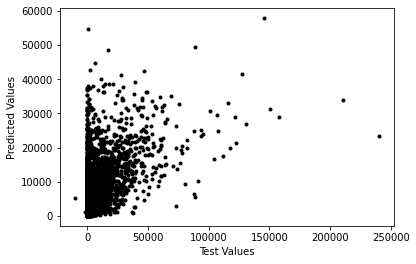

In [38]:
# *****************************************************************
rf_rand_search_rmses = {}
rf_rand_search_models = []
print('**************************RF WITH RAND SEARCH CV MODELS**************************')
tstart = dt.datetime.now()
print('*'*49)
print(f'*\tstarted: {start}\t*')
print('*'*49)
# --------------------------------------------------------
for idx,t in enumerate(targets):
    print(f'RF model with target \"{targets[idx]}\"')
    print(f'RF Model for {t} with {len(dataloaders_by_tgt_filtered[idx][0].columns)} features')
    # ---------------------------------------------------------------------------------------------------
    # time the randomized search
    start = time.time()

    params = {
        "n_estimators": randint(10, 150), # randint from scipy.stats (imported previously)
        "max_features": uniform(0.05, 0.95), #uniform from scipy.stats (imported previously)
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 20),
        "bootstrap": [True, False]
    }
    rfr = RandomForestRegressor(random_state=42)
    rfr_rs = RandomizedSearchCV(rfr,param_distributions=params,random_state=42,
                                n_iter=25,cv=5,verbose=1,n_jobs=-1,return_train_score=True)
    rfr_rs.fit(dataloaders_by_tgt_filtered[idx][0], dataloaders_by_tgt_filtered[idx][1])
    end = time.time()
    delta = end - start
    print(f"took {delta:.2f} seconds to perform randomized search")
    print(f'best params: {rfr_rs.best_params_}')
    # ---------------------------------------------------------------------------------------------------
    # fit model with best params from randomized search
    rfr = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score = True, **rfr_rs.best_params_,)
    m = rfr.fit(dataloaders_by_tgt_filtered[idx][0], dataloaders_by_tgt_filtered[idx][1])
    rf_rand_search_models.append(m)
    # look at oob score
    print(f'OOB Score: {m.oob_score_}')
    # ---------------------------------------------------------------------------------------------------
    # compare rmse
    rmse = plot_model_results(model=m, test_x=dataloaders_by_tgt_filtered[idx][2]
                              ,test_y=dataloaders_by_tgt_filtered[idx][3]
                              ,method_name='RF Random Search CV', comp_rmse=filtered_rf_rmses[t])
    rf_rand_search_rmses[t]=(rmse)
    # ---------------------------------------------------------------------------------------------------
    print('*'*80)
# --------------------------------------------------------
print('*'*49)
tend = dt.datetime.now()
print(f'*\tended: {tend}\t*')
print(f'*\telapsed time: {(tend-tstart)}\t\t*')
print('*'*49)

In [39]:
filtered_rf_rmses

{'ChargeHours': 48.434262537826186,
 'ProductionRevActual': 9363.191750882717,
 'Cost': 2085.0549581288415,
 'NumAssociatesOnJob': 2.170539793423609}

### Bayesian Optimization with Cross Validation

**************************RF WITH BAYOPT MODELS**************************
*************************************************
*	started: 1650301900.4032903	*
*************************************************
RF Model with Bayesian Optimization for ChargeHours with 15 features
took 302.44 seconds to perform bayesian optimization
best params: {'n_estimators': 150, 'max_features': 0.4953103524264355, 'min_samples_split': 20, 'min_samples_leaf': 1, 'bootstrap': 1}
OOB Score: 0.28709221707762433
R^2 on Test: 0.3196
New RMSE on test(RF BayOpt): 48.7815
Old RMSE on test (RF): 48.434262537826186
RMSE Change (if neg, its an improvement): 0.3473
********************************************************************************
RF Model with Bayesian Optimization for ProductionRevActual with 15 features
took 315.63 seconds to perform bayesian optimization
best params: {'n_estimators': 150, 'max_features': 0.8424929714845363, 'min_samples_split': 2, 'min_samples_leaf': 20, 'bootstrap': 1}
OOB Score: 0

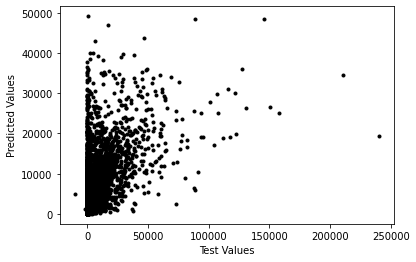

In [40]:
np.random.seed(42)
# USING TEMPLATE CODE FROM DS775 HOMEWORK 8
hp_bounds = [{'name': 'n_estimators','type': 'discrete','domain': (10, 150)}, 
             {'name': 'max_features','type': 'continuous','domain': (0.05, 1.0)}, 
             {'name': 'min_samples_split','type': 'discrete','domain': (2, 20)},
             {'name': 'min_samples_leaf','type': 'discrete','domain': (1, 20)}, 
             {'name': 'bootstrap','type': 'discrete','domain': (0, 1)}]

rfr_bayopt_models = []
rfr_bayopt_rmses = {}
rfr_bayopt_hyperparameter_sets = []

print('**************************RF WITH BAYOPT MODELS**************************')
tstart = dt.datetime.now()
print('*'*49)
print(f'*\tstarted: {start}\t*')
print('*'*49)
for idx,t in enumerate(targets):
    print(f'RF Model with Bayesian Optimization for {t} with {len(dataloaders_by_tgt_filtered[idx][0].columns)} features')
    # time the bayesian optimization
    start = time.time()
    # ---------------------------------------------------------------------------------------------------
    # Optimization objective - used from ds775 project 2 with some exits
    def cv_score(hyp_parameters):
        hyp_parameters = hyp_parameters[0]
        rf_model = RandomForestRegressor(random_state=0,
                                 n_estimators=int(hyp_parameters[0]),
                                 max_features=hyp_parameters[1],
                                 min_samples_split=int(hyp_parameters[2]),
                                 min_samples_leaf=int(hyp_parameters[3]),
                                 bootstrap=bool(hyp_parameters[4]))
        
        scores = cross_val_score(rf_model, X=dataloaders_by_tgt_filtered[idx][0],
                                 y=dataloaders_by_tgt_filtered[idx][1],cv=KFold(n_splits=5))
        return np.array(scores.mean())  # return average of 5-fold scores
    
    # run bayopt
    optimizer = BayesianOptimization(f=cv_score,domain=hp_bounds,model_type='GP',acquisition_type='EI',
                                     acquisition_jitter=0.05,exact_feval=True,maximize=True,verbosity=False)
    optimizer.run_optimization(max_iter=20,verbosity=False) # should run silent
    # ---------------------------------------------------------------------------------------------------
    # ----------------- get best hyperparamters ---------------------
    best_hyp_set = {}
    for i in range(len(hp_bounds)):
        if hp_bounds[i]['type'] == 'continuous':
            best_hyp_set[hp_bounds[i]['name']] = optimizer.x_opt[i]
        else:
            best_hyp_set[hp_bounds[i]['name']] = int(optimizer.x_opt[i])
    rfr_bayopt_hyperparameter_sets.append(best_hyp_set)
    # ---------------------------------------------------------------------------------------------------
    end = time.time()
    delta = end - start
    print(f"took {delta:.2f} seconds to perform bayesian optimization")
    print(f'best params: {best_hyp_set}')
    # ---------------------------------------------------------------------------------------------------
    # fit model with best params from randomized search
    rfr = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score = True, **best_hyp_set)
    m = rfr.fit(dataloaders_by_tgt_filtered[idx][0], dataloaders_by_tgt_filtered[idx][1])
    rfr_bayopt_models.append(m)
    # look at oob score
    print(f'OOB Score: {m.oob_score_}')
    # ---------------------------------------------------------------------------------------------------
    # compare rmse
    rmse = plot_model_results(model=m, test_x=dataloaders_by_tgt_filtered[idx][2]
                              ,test_y=dataloaders_by_tgt_filtered[idx][3]
                              ,method_name='RF BayOpt', comp_rmse=filtered_rf_rmses[t])
    rfr_bayopt_rmses[t]=(rmse)
     # ---------------------------------------------------------------------------------------------------
    print('*'*80)
tend = dt.datetime.now()
print(f'*\tended: {tend}\t*')
print(f'*\telapsed time: {(tend-tstart)}\t\t*')
print('*'*49)

---
## final model: vanilla random forest w/o tuning...hmm
### create a table with all of our stats for the models, i.e. RMSE results for each target, for each model trained in each type of model

In [42]:
model_classes = ['Decision Tree', 'Random Forest (all features)', 'Random Forest (filtered by fi)', 'Random Forest (filtered features)', 'XG Boost (Rand Search CV,filtered features)'
                 , 'XG Boost (BayOpt,filtered features)', 'Neural Net (Fastai Tabular,filtered features)', 'Random Forest (using NN Entity Embeddings)'
                 , 'XG Boost (using NN Entity Embeddings)', 'Random Forest (Rand Search CV)', 'Random Forest (BayOpt)']

# cleanup our value dicts
dt_results_2= {k.replace(' pred stats (rmse,r2)',''):v[0] for k,v in dt_results.items()} # it was messy
rf_base_results_2 = {k.replace(' pred stats (rmse,r2)',''):v[0] for k,v in rf_base_results.items()} # it was messy
nn_mod_rmse_dict = dict(zip(targets,[float(x) for x in best_nn_model_rmses])) # convert from tensor list

# instantiate our dict object
value_dicts = [dt_results_2, rf_base_results_2,rf_with_fi_fs_rmses,filtered_rf_rmses,xgb_rmses
              ,xgb_bayopt_rmses,nn_mod_rmse_dict,emb_rmse_rf
              ,emb_rmse_xgb,rf_rand_search_rmses,rfr_bayopt_rmses]
build_dict = dict(zip(model_classes, [{f'{k}_rmse':v for k,v in res.items()} for res in value_dicts]))

# create transposed df
rmse_dict = pd.DataFrame.from_dict(build_dict).T
               
# add n-feature col
n_features = [20,20,10,15,15,15,20,20,20,15,15]
rmse_dict['num_features'] = n_features

#show
#rmse_dict.style.highlight_min(color='lightgreen', axis=0, subset=['ChargeHours_rmse','ProductionRevActual_rmse','Cost_rmse','NumAssociatesOnJob_rmse'])
rmse_dict.style.highlight_min(color='lightgreen', axis=0, subset=['ChargeHours_rmse','ProductionRevActual_rmse','Cost_rmse','NumAssociatesOnJob_rmse'])

,ChargeHours_rmse,ProductionRevActual_rmse,Cost_rmse,NumAssociatesOnJob_rmse,num_features
Decision Tree,51.413817,9793.732332,2239.518578,2.344544,20
Random Forest (all features),48.657518,9381.848527,2103.582892,2.155260,20
Random Forest (filtered by fi),48.705083,9572.954489,2138.585326,2.176371,10
Random Forest (filtered features),48.434263,9363.191751,2085.054958,2.170540,15
"XG Boost (Rand Search CV,filtered features)",49.221001,9607.276367,2158.280518,2.161184,15
"XG Boost (BayOpt,filtered features)",52.766140,9542.208008,2233.725586,2.349012,15
"Neural Net (Fastai Tabular,filtered features)",52.536297,27331.042969,4001.887207,2.594106,20
Random Forest (using NN Entity Embeddings),50.880183,10287.799171,2273.841912,2.345997,20
XG Boost (using NN Entity Embeddings),54.391418,10744.569336,2412.375488,2.398142,20
Random Forest (Rand Search CV),48.957268,9426.753996,2105.287622,2.143382,15


### saving the final models



In [46]:
import joblib
import pathlib
bm_savepath = pathlib.PurePath('./best_models')
#tday = dt.date.today().strftime('%m-%d-%Y')
# best ChargeHours model
joblib.dump(models_filtered_dfs[0], f'{bm_savepath}/ChargeHours.pkl')
# best ProductionRevActualModel
joblib.dump(models_filtered_dfs[1], f'{bm_savepath}/ProductionRevActual.pkl')
# best Cost model
joblib.dump(models_filtered_dfs[2], f'{bm_savepath}/Cost.pkl')
# best NumAssociates model
joblib.dump(rf_rand_search_models[3], f'{bm_savepath}/NumAssociatesOnJob.pkl')

['best_models/NumAssociatesOnJob.pkl']

In [44]:
# to load later...
# regr =  joblib.load('model.pkl'
# regr.predict(new_data)

---

In [45]:
# final run time of entire notebook - only makes sense on a KERNEL > RESTART AND RUN ALL
print('*'*49)
full_nb_run_end = dt.datetime.now()
print(f'*\tended: {full_nb_run_end}\t*')
print(f'*\telapsed time: {(full_nb_run_end-full_nb_run_start)}\t\t*')
print('*'*49)

*************************************************
*	ended: 2022-04-18 13:39:24.994217	*
*	elapsed time: 2:02:17.696826		*
*************************************************
